In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
import pathlib
import PIL
import time
import zipfile
import random
from tensorflow import keras as ks
from tensorflow.keras.layers import *
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [40]:
sub=pd.read_csv("../input/animal-classification-challenge/sample_submission (4).csv", sep=",")

In [41]:
sub

,"id,label"
0,"ASG001dw7n_1.jpeg,1"
1,"ASG001dw7q_2.jpeg,0"
2,"ASG001dw7s_1.jpeg,0"
3,"ASG001dw7w_1.jpeg,1"
4,"ASG001dw7x_0.jpeg,0"
...,...
5994,"ASG001g7r0_1.jpeg,"
5995,"ASG001g7r0_2.jpeg,"
5996,"ASG001g7ry_1.jpeg,"
5997,"ASG001g7sb_0.jpeg,"


In [42]:
test=[]
id_=[]
diir="../input/animal-classification-challenge/test/test/"
for i in os.listdir(diir):
    id_.append(i)
    path=diir+i
    test.append(path)
    

In [43]:
train_zebra=[]
diir="../input/animal-classification-challenge/train_zebras/train_zebras/"
for i in os.listdir(diir):
    path=diir+i
    train_zebra.append(path)
    

In [44]:
train_ele=[]
diir="../input/animal-classification-challenge/train_elephants/train_elephants/"
for i in os.listdir(diir):
    path=diir+i
    train_ele.append(path)

In [45]:
z=[0 for i in range(len(train_zebra))]
e=[1 for i in range(len(train_ele))]
L=train_ele+train_zebra
l=e+z


In [46]:
len(l)

13999

In [47]:
train_df=pd.DataFrame({"path":L,"label":l})

In [49]:
train_df=train_df.sample(frac=1)

In [50]:
train_df

,path,label
13631,../input/animal-classification-challenge/train...,0
10470,../input/animal-classification-challenge/train...,0
4581,../input/animal-classification-challenge/train...,1
1398,../input/animal-classification-challenge/train...,1
11254,../input/animal-classification-challenge/train...,0
...,...,...
5620,../input/animal-classification-challenge/train...,1
11940,../input/animal-classification-challenge/train...,0
12703,../input/animal-classification-challenge/train...,0
5531,../input/animal-classification-challenge/train...,1


In [51]:
train_datagenerator = ImageDataGenerator(
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest',
    validation_split=0.1)

In [52]:
train_generator = train_datagenerator.flow_from_dataframe(
    train_df, 
    x_col='path', 
    y_col='label',
    target_size=(330, 330), 
    color_mode='rgb', 
    class_mode='raw', 
    batch_size=32, 
    shuffle=True, 
    seed=1,
    subset='training')
validation_generator = train_datagenerator.flow_from_dataframe(
    train_df , 
    x_col='path',
    y_col='label',
    target_size=(330, 330),
    color_mode='rgb', 
    class_mode='raw', 
    batch_size=4, 
    shuffle=True,
    seed=1, 
    subset='validation'
)

Found 12600 validated image filenames.
Found 1399 validated image filenames.


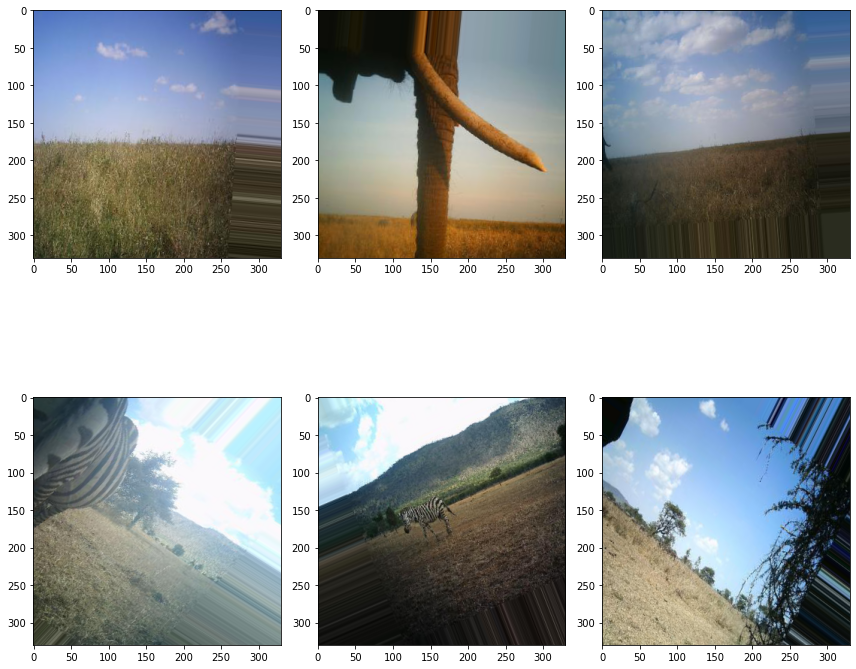

In [53]:
# plt.figure(figsize=(12, 12))
# for i in range(0, 6):
#     plt.subplot(2, 3, i+1)
#     for X_batch, Y_batch in validation_generator:
#         image = X_batch[0]
#         plt.imshow(image)
#         break
# plt.tight_layout()
# plt.show()

In [55]:
import tensorflow_addons as tfa
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from tensorflow.keras.applications.resnet50 import ResNet50

model = ResNet50(include_top=False, input_shape=(330, 330, 3))
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
class2 = Dense(512, activation='relu')(class1)
class3 = Dense(256, activation='relu')(class2)
output = Dense(2, activation='softmax')(class3)
# define new model
model = Model(inputs=model.inputs, outputs=output)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [56]:
batch_size=20
FAST_RUN = False
epochs=5 if FAST_RUN else 20
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/20
394/394 [==============================] - 420s 1s/step - loss: 1.5685 - acc: 0.7448 - val_loss: 0.7361 - val_acc: 0.5111
Epoch 2/20
394/394 [==============================] - 410s 1s/step - loss: 0.3121 - acc: 0.8683 - val_loss: 0.6869 - val_acc: 0.5783
Epoch 3/20
394/394 [==============================] - 417s 1s/step - loss: 0.1907 - acc: 0.9280 - val_loss: 0.3635 - val_acc: 0.8792
Epoch 4/20
394/394 [==============================] - 417s 1s/step - loss: 0.1548 - acc: 0.9388 - val_loss: 0.1835 - val_acc: 0.9385
Epoch 5/20
394/394 [==============================] - 412s 1s/step - loss: 0.1446 - acc: 0.9437 - val_loss: 4.8748 - val_acc: 0.6154
Epoch 6/20
101/394 [======>.......................] - ETA: 4:42 - loss: 0.1556 - acc: 0.9443

KeyboardInterrupt: 

In [57]:
p=[]
from PIL import Image
for i in test:
    img = np.array(Image.open(i).resize((330,330))).reshape((1, 330, 330 , 3))
    out = model(img)
#     print(out)
#     print(tf.get_static_value(tf.math.argmax(out, axis=1)))
    p.append(tf.get_static_value(tf.math.argmax(out, axis=1)))

In [58]:
tf.get_static_value(tf.math.argmax(out, axis=1))

array([1])

In [60]:
p=[i[0] for i in p]

In [62]:
submission=pd.DataFrame({"id":id_,"label":p})
submission.to_csv("sub4.csv", index=False)